# Introduction/Abstract

Data set from King County Washington.

# Packages Needed/Setting Global Variables

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def Decade(List):
    decade_list=[]
    oldest = List.min()
    i=0
    for x in List:
        i += 1
        while len(decade_list) < i:
            if (x >= oldest) & (x < (oldest+10)):
                decade_list.append('{}-{}'.format(oldest,(oldest+10)))
            oldest += 10
        oldest = List.min()
    return decade_list

In [3]:
def zoningLat(List):
    lowest = List.min()
    highest = List.max()
    distance = highest - lowest
    distance = math.ceil(distance*69)
    zones = []
    for entry in List:
        for zone in list(range(1,distance+1)):
            if ((lowest+(zone-1)/69) <= entry) &(entry < (lowest + zone/69)):
                zones.append(zone)
    return zones

def zoningLong(List):
    lowest = List.min()
    highest = List.max()
    distance = highest-lowest
    distance = math.ceil(distance*54.6)
    zones = []
    for entry in List:
        for zone in list(range(1,distance+1)):
            if ((lowest+(zone-1)/54.6) <= entry) & (entry < (lowest + zone/54.6)):
                zones.append(zone)
    return zones

In [4]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            #included.remove(worst_feature)
            del included[worst_feature]
            
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# EDA

## Questions about the Data

## Import and Clean the Data

In [5]:
# Import the dataset
df = pd.read_csv('kc_house_data.csv')

#Dropping id column
df = df.drop(['id'],axis=1)

# Creating a new column for the year sold, dropping origianl date
df['year_sold'] = df.date.apply(lambda x: x[-4:]).astype(int)
df = df.drop(['date'], axis=1)

# Changing bedroom number for outlier, I think it was a typo of hitting 3 twice
# based off of the sqft
df.at[15856, 'bedrooms'] = 3

# Replacing NaN values in 'waterfront' with 0
df['waterfront'] = df['waterfront'].fillna(0)

# Replacing NaN values in view with the median/mode value which is 0 (63 entries)
# 0 means house was not viewed
df['view'] = df['view'].fillna(0)

# Replacing ? in sqft_basement and converting to float
df['sqft_basement'] = df['sqft_basement'].replace('?',0).astype(float)

# yr_renovated and renovated columns
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['Renovated'] = df['yr_renovated'] > 0
df['Renovated'] = df['Renovated'].astype(int)
df['yr_renovated'] = df['yr_renovated'].replace(0,df['yr_built'])

#Adding column for age when sold
df['Age_When_Sold'] = df['year_sold'] - df['yr_built']

#Adding column for years since renovation when sold and dropping yr_renovated
df['Age_Since_Renovation'] = df['year_sold'] - df['yr_renovated']

#Adding interaction variable Renovated*Age since renovation
df['Renovated*Age'] = df['Renovated'] * df['Age_Since_Renovation']

#Adding zones for Lat and Long
df['Lat_Zones'] = zoningLat(df['lat'])
df['Long_Zones'] = zoningLong(df['long'])
df['Lat_Zones'] = df['Lat_Zones'].astype(str)
df['Long_Zones'] = df['Long_Zones'].astype(str)
#df['Zones'] = df['Lat_Zones'] + 'x' + df['Long_Zones']
df = df.drop(['lat','long','Long_Zones','Lat_Zones'],axis=1)

#Grouping year built by decade
df['yr_built'] = Decade(df.yr_built)

#Dropping 'year_sold',only seems to have two years, not valuable category
df = df.drop(['year_sold'], axis=1)

## Linearity and preprocessing

In [6]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Renovated,Age_When_Sold,Age_Since_Renovation,Renovated*Age
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1950-1960,1955.0,98178,1340,5650,0,59,59.0,0.0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1950-1960,1991.0,98125,1690,7639,1,63,23.0,23.0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1930-1940,1933.0,98028,2720,8062,0,82,82.0,0.0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1960-1970,1965.0,98136,1360,5000,0,49,49.0,0.0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1980-1990,1987.0,98074,1800,7503,0,28,28.0,0.0


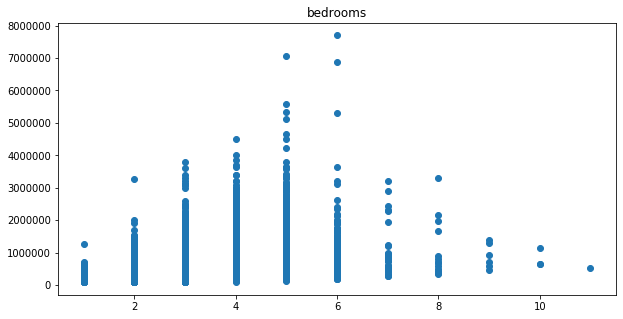

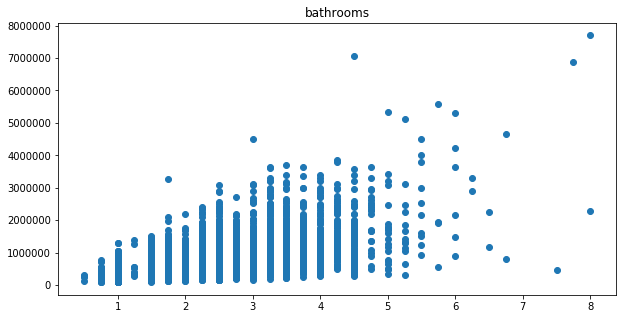

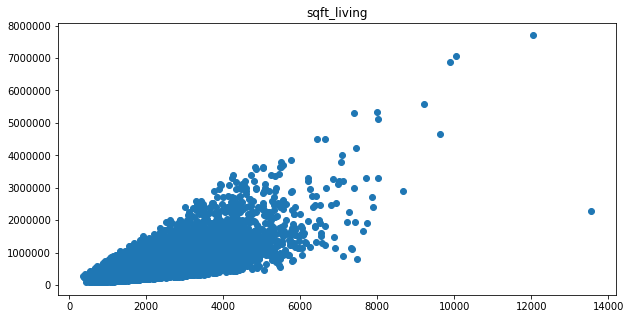

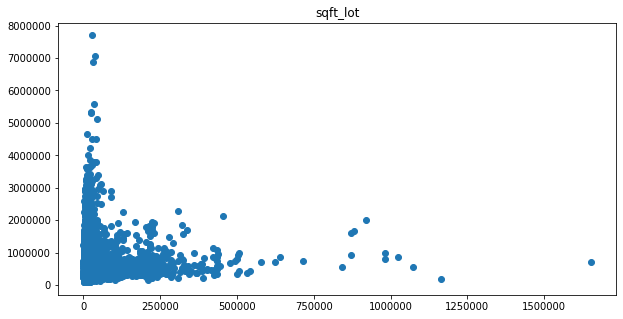

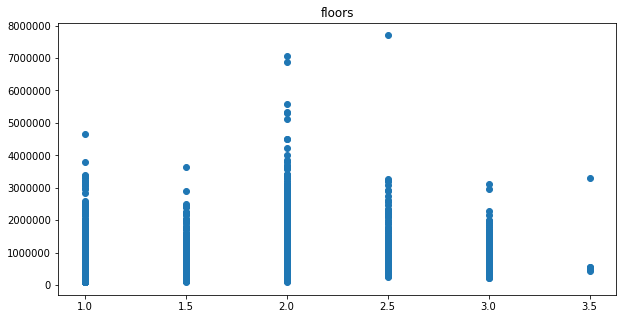

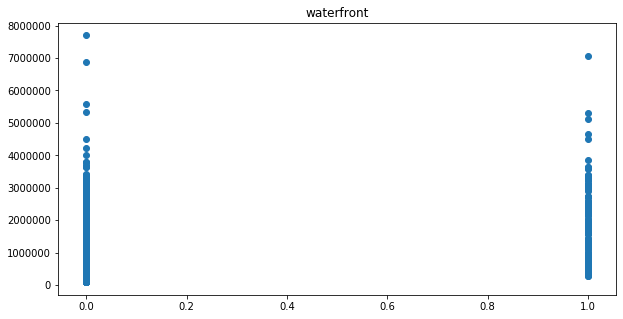

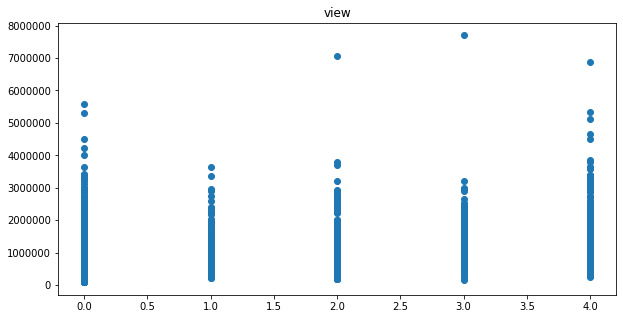

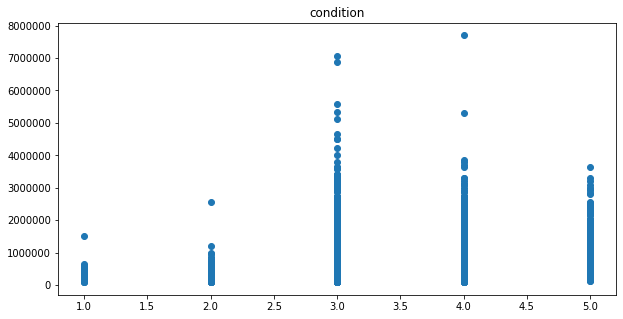

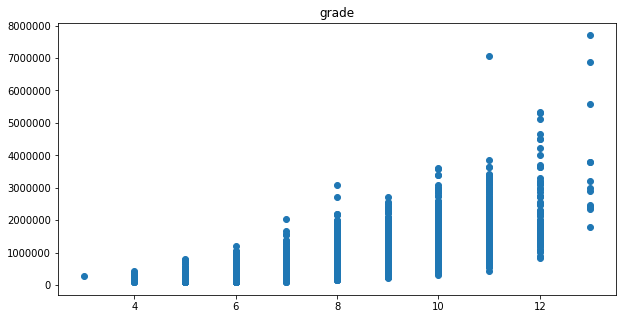

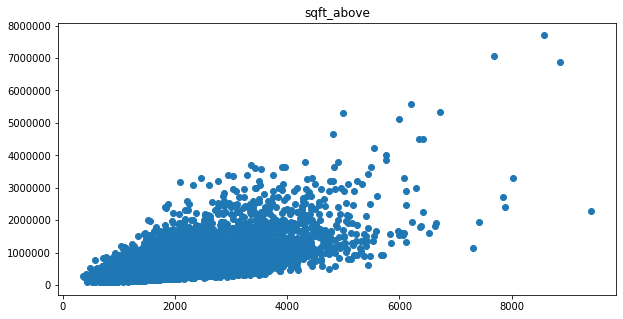

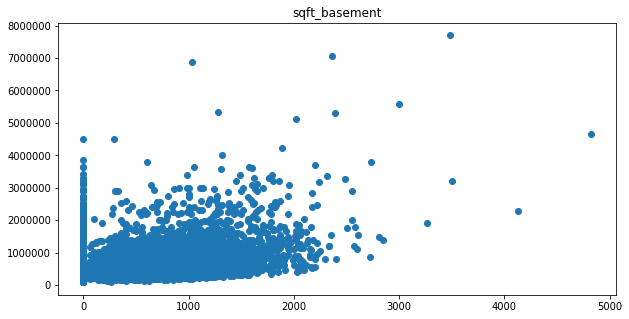

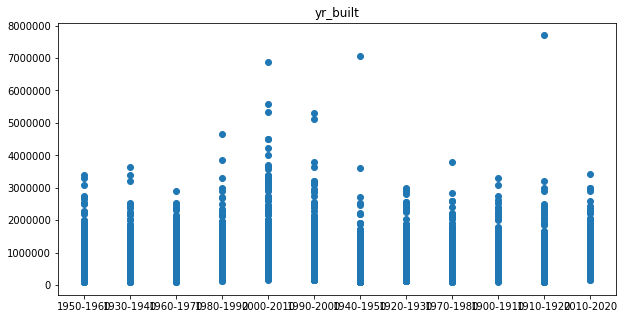

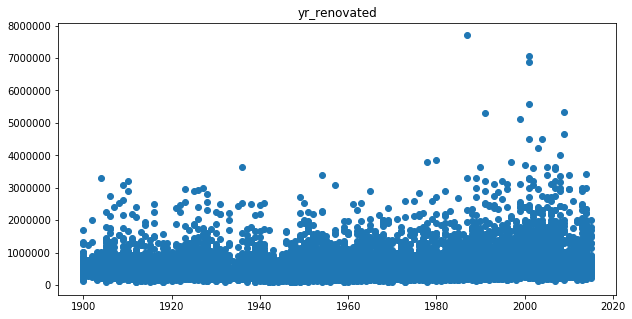

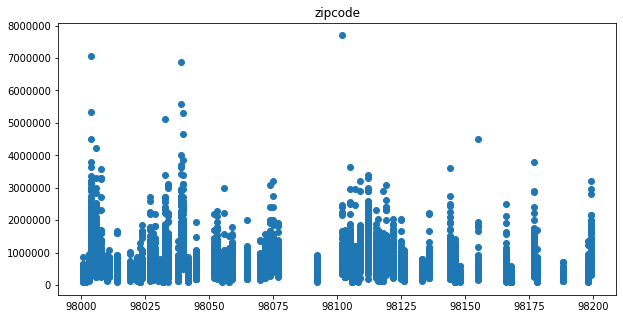

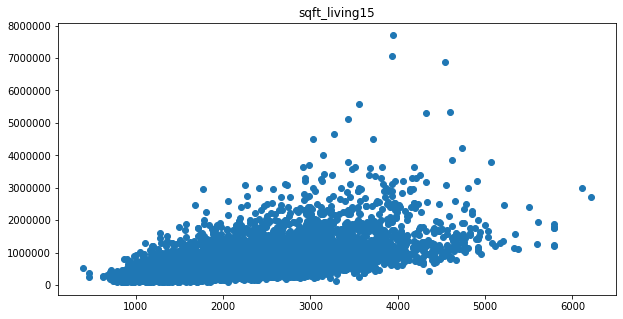

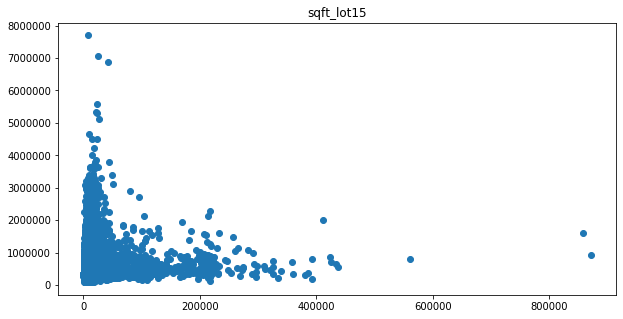

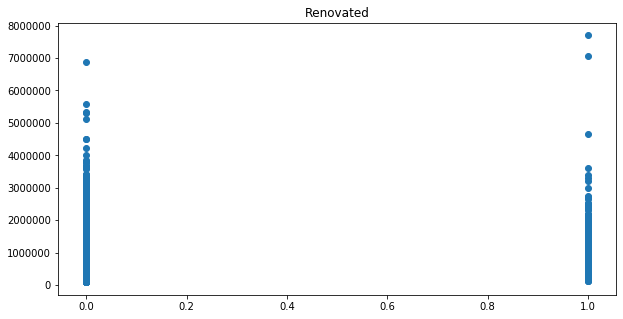

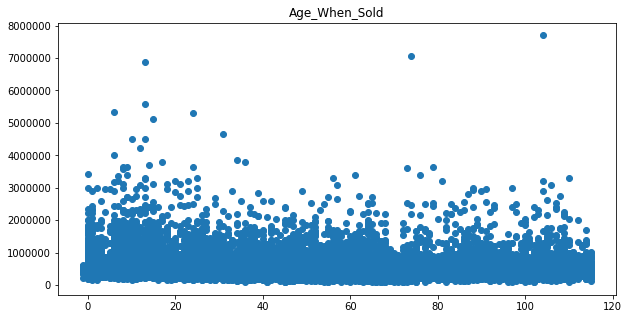

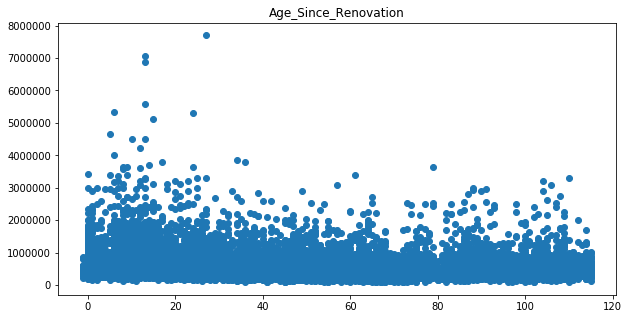

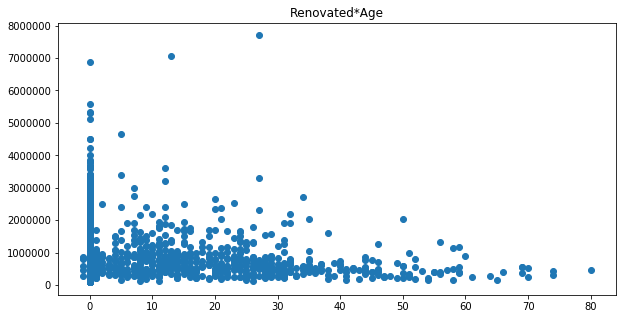

In [7]:
col = list(df.columns)
col.remove('price')
for column in col:
    plt.figure(figsize=(10,5))
    plt.scatter(x=df[column],y=df['price'])
    plt.title(column)
    plt.show()

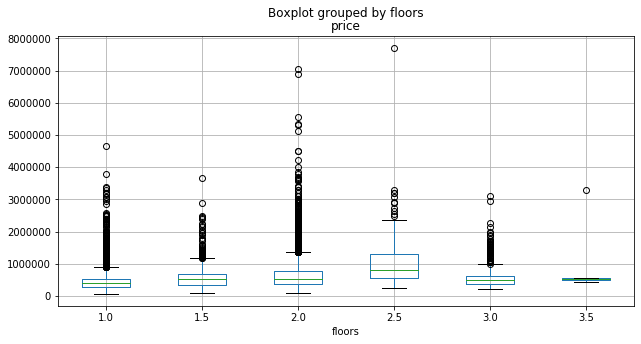

In [8]:
df.boxplot(column='price',by='floors',figsize=(10,5));

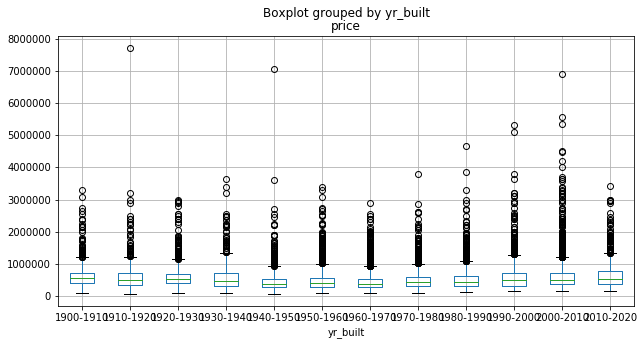

In [9]:
df.boxplot(column='price',by='yr_built',figsize=(10,5));

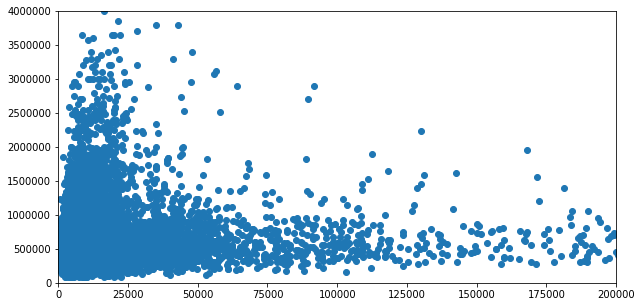

In [10]:
plt.figure(figsize=(10,5))
plt.xlim((-.05,200000))
plt.ylim((-.05,4000000))
plt.scatter(x=df['sqft_lot'],y=df['price'])
plt.show()

Looking at linearity. It looks like the features that could have strong linear relationships are:
1. bathrooms
2. sqft_living
3. sqft_above
4. sqft_living15
5. grade

Ones that seem like they could have a mild linear relationship are:

1. bedrooms
2. grade
3. sqft_basement
4. condition
5. Floors

The variable grade seems like it's actually exponential, might be worth exploring later.

In [11]:
# These are the variables that are going to be dropped
# for not meeting the linearity assumption, some categoricals are going to stay
# for example zipcode

non_linearity = ['sqft_lot','yr_built','yr_renovated','sqft_lot15',
                 'Age_When_Sold','Age_Since_Renovation','Renovated*Age']

df = df.drop(non_linearity,axis=1)

In [12]:
#Creating Dummie Variables double check this list
#Taking out bedrooms, bathrooms, floors, view, condition
dummy_list = ['grade', 'zipcode'
                ] #Add 'Zones' back in later
dum=df[dummy_list].astype('category')
dummies = pd.get_dummies(dum[dummy_list],prefix=dummy_list,drop_first=True)
df_preprocessed = df.drop(dummy_list, axis=1)
df_preprocessed = pd.concat([df_preprocessed,dummies],axis=1)

## Notes

# Modeling

## First Model

In [13]:
#Omitting zones for now, too much data to process
y = df_preprocessed['price']
X = df_preprocessed.drop(['price'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
X_train_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     1064.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:35:28   Log-Likelihood:            -2.3124e+05
No. Observations:               17277   AIC:                         4.626e+05
Df Residuals:                   17203   BIC:                         4.632e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.415e+06   1.06e+05    -41.575      0.000   -4.62e+06   -4.21e+06
grade_7       -1.236e+05   5126.474    -24.119      0.000   -1.34e+05   -1.14e+05
grade_6       -1.012e+05   7167.458    -14.119      0.000   -1.15e+05   -8.71e+04
waterfront      7.27e+05   1.59e+04     45.745      0.000    6.96e+05    7.58e+05
grade_8       -1.024e+05   4433.107    -23.093      0.000   -1.11e+05   -9.37e+04
sqft_basement   114.2129      3.796     30.084      0.000     106.771     121.654
sqft_above     2.058e+06   4.64e+04     44.334      0.000    1.97e+06    2.15e+06
zipcode_98004  7.442e+05   1.05e+04     71.206      0.000    7.24e+05    7.65e+05
zipcode_98039  1.246e+06   2.61e+04     47.797      0.000    1.19e+06     1.3e+06
zipcode_98112   6.12e+05   1.15e+04     53.242      0.000    5.89e+05    6.35e+05
view           5.052e+04   1877.425     26.911      0.000    4.68e+04    5.42e+04
grade_12       9.958e+05    1.9e+04     52.504      0.000    9.59e+05    1.03e+06
zipcode_98040   4.77e+05   1.12e+04     42.526      0.000    4.55e+05    4.99e+05
grade_13       2.259e+06   5.63e+04     40.116      0.000    2.15e+06    2.37e+06
grade_11       4.534e+05   9960.895     45.513      0.000    4.34e+05    4.73e+05
grade_10       1.709e+05   6461.491     26.454      0.000    1.58e+05    1.84e+05
zipcode_98105  4.499e+05   1.22e+04     37.020      0.000    4.26e+05    4.74e+05
zipcode_98119  4.903e+05   1.34e+04     36.513      0.000    4.64e+05    5.17e+05
zipcode_98103  3.351e+05   8053.381     41.612      0.000    3.19e+05    3.51e+05
zipcode_98115  3.277e+05   7929.976     41.327      0.000    3.12e+05    3.43e+05
zipcode_98033   3.38e+05   9036.074     37.410      0.000     3.2e+05    3.56e+05
zipcode_98199  3.745e+05   1.06e+04     35.321      0.000    3.54e+05    3.95e+05
zipcode_98117  3.141e+05   8238.806     38.120      0.000    2.98e+05     3.3e+05
zipcode_98109  4.722e+05   1.69e+04     27.990      0.000    4.39e+05    5.05e+05
zipcode_98102  4.819e+05   1.74e+04     27.628      0.000    4.48e+05    5.16e+05
zipcode_98107  3.449e+05   1.13e+04     30.526      0.000    3.23e+05    3.67e+05
zipcode_98122  3.326e+05   1.11e+04     29.898      0.000    3.11e+05    3.54e+05
zipcode_98023 -5.562e+04   8480.869     -6.558      0.000   -7.22e+04    -3.9e+04
condition      3.227e+04   1999.882     16.137      0.000    2.84e+04    3.62e+04
zipcode_98116  2.839e+05   1.03e+04     27.506      0.000    2.64e+05    3.04e+05
zipcode_98042 -2.116e+04   8093.836     -2.614      0.009    -3.7e+04   -5293.500
zipcode_98092 -4.829e+04   9987.060     -4.835      0.000   -6.79e+04   -2.87e+04
zipcode_98144  2.663e+05   1.02e+04     26.088      0.000    2.46e+05    2.86e+05
zipcode_98006  2.233e+05   8694.957     25.685      0.000    2.06e+05     2.4e+05
zipcode_98052  2.124e+05   8022.703     26.471   

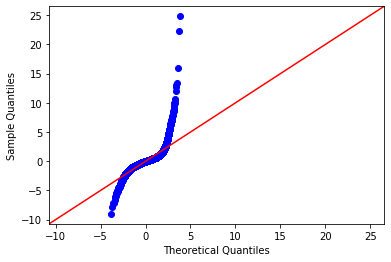

In [47]:
residuals = model.resid
qq1 = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

## Looking at Multicollinearity

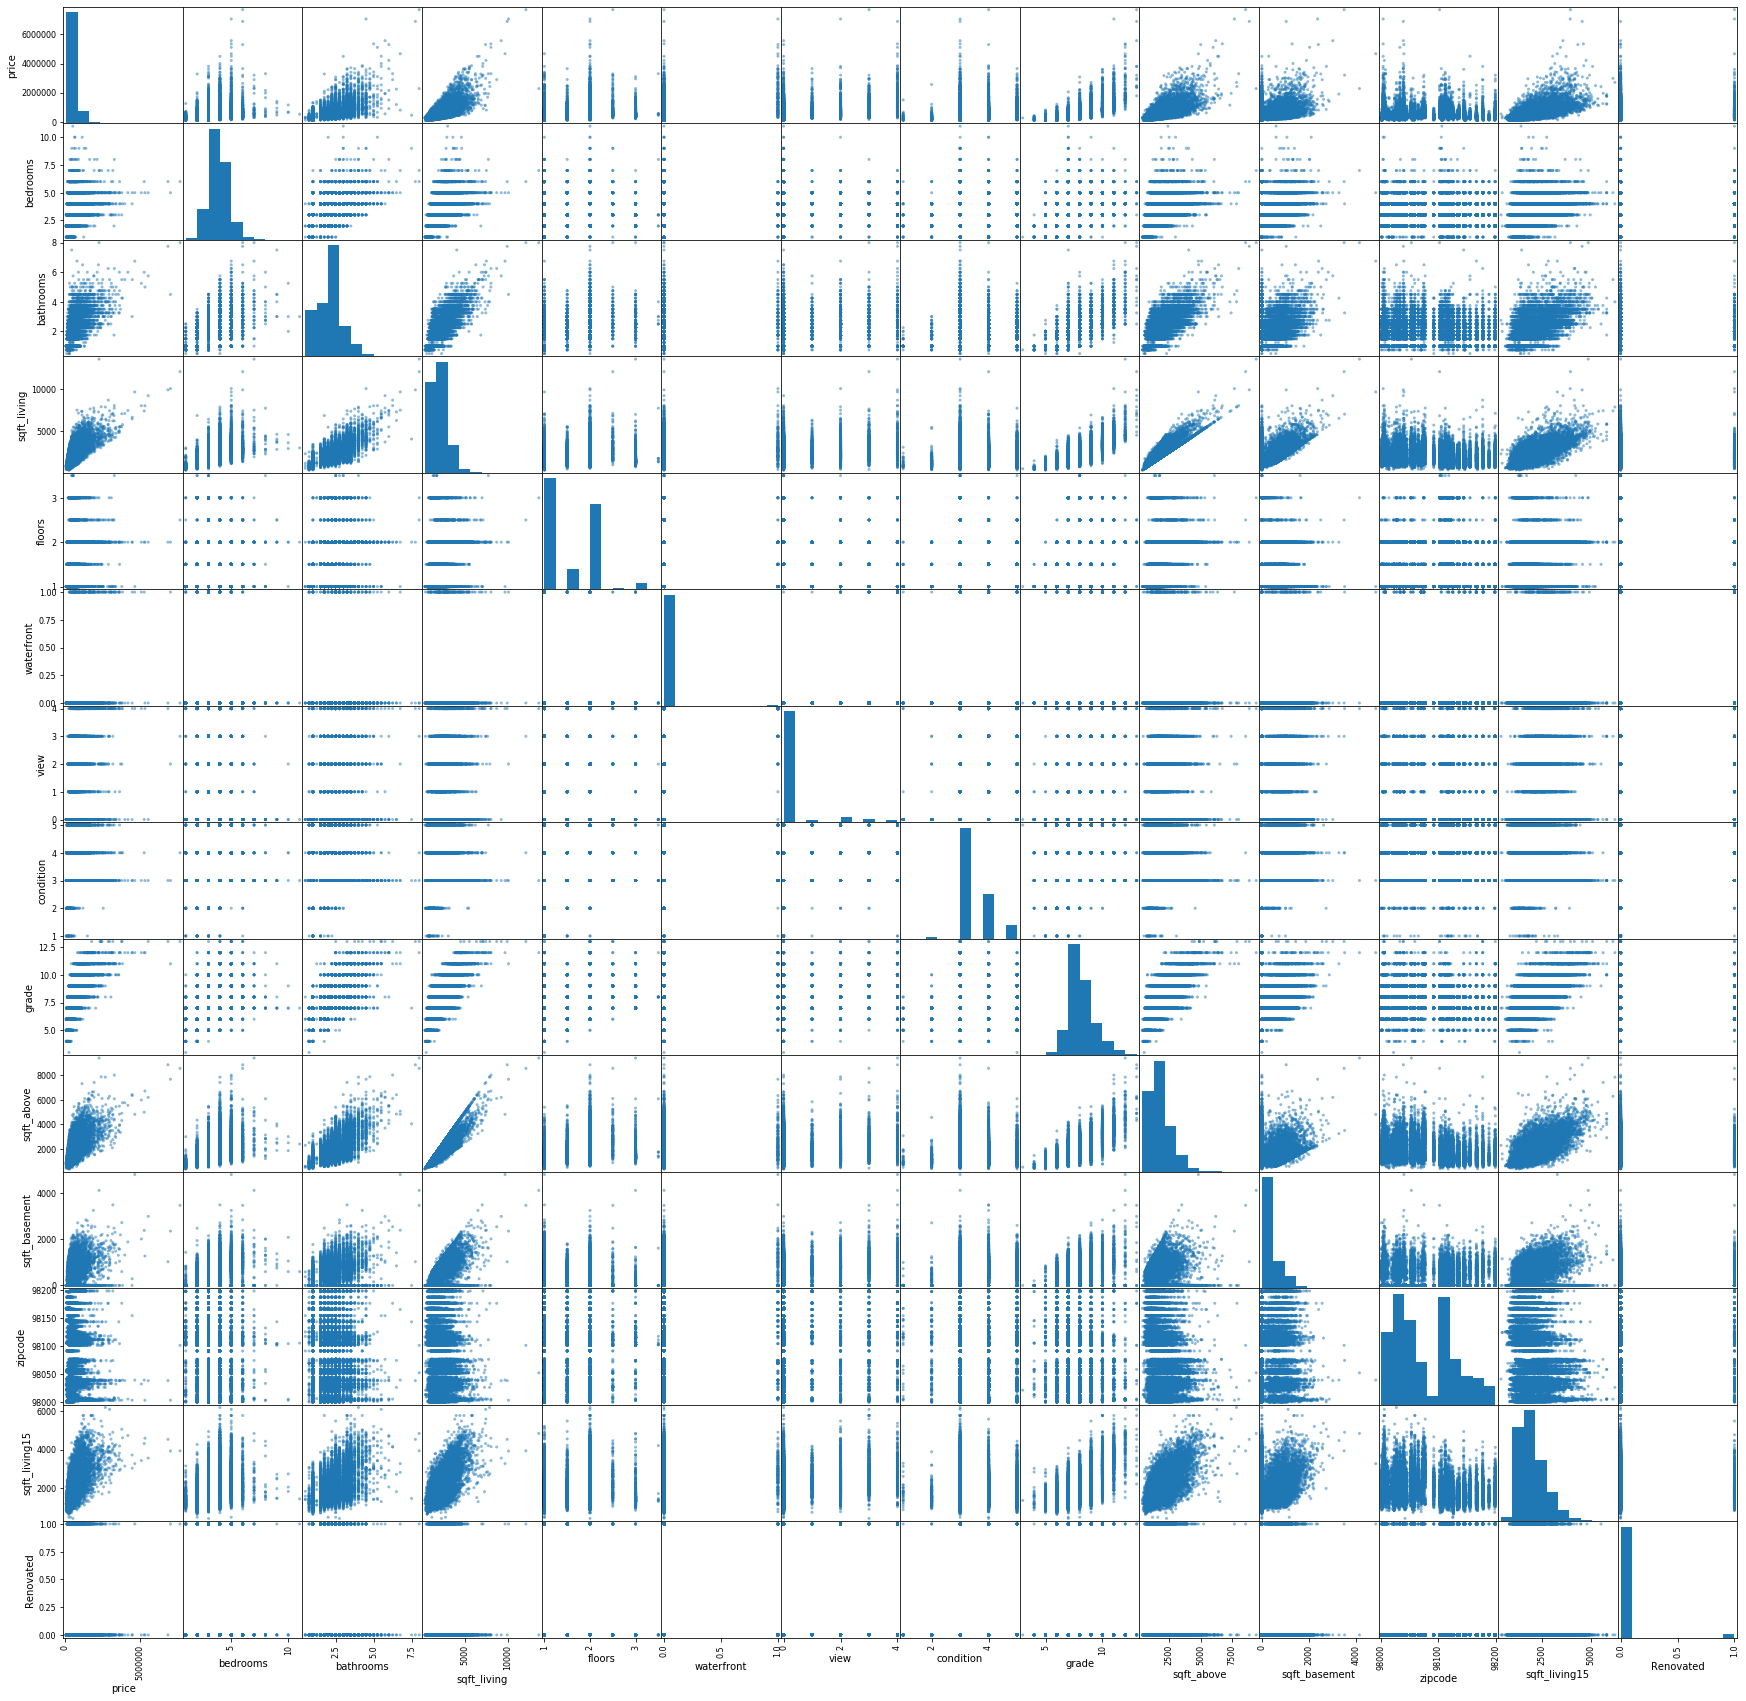

In [15]:
pd.plotting.scatter_matrix(df,figsize  = [30, 30]);
plt.show()

In [16]:
test_corr=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
test_corr['pairs'] = list(zip(test_corr.level_0, test_corr.level_1))
test_corr.set_index(['pairs'],inplace=True)
test_corr.drop(['level_0','level_1'],axis=1,inplace=True)
test_corr.columns = ['cc']
test_corr.drop_duplicates(inplace=True)
test_corr[(test_corr.cc >.75) & (test_corr.cc<1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(sqft_living, grade)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(grade, sqft_above)",0.756073
"(bathrooms, sqft_living)",0.755758


It looks like sqft_living is highly correlated with a bunch of variables. Let's take out sqft_living to see if this will fix the correlation.

In [17]:
df = df.drop(['sqft_living'],axis=1)

In [18]:
test_corr2=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
test_corr2['pairs'] = list(zip(test_corr2.level_0, test_corr2.level_1))
test_corr2.set_index(['pairs'],inplace=True)
test_corr2.drop(['level_0','level_1'],axis=1,inplace=True)
test_corr2.columns = ['cc']
test_corr2.drop_duplicates(inplace=True)
test_corr2[(test_corr2.cc >.75) & (test_corr2.cc<1)]

,cc
pairs,
"(grade, sqft_above)",0.756073


Sqft_above and grade also seems to be correlated but I believe they are very different and just happen to be correlated so I'm going to keep those variables.

In [19]:
#dropping sqft_living from actual test/train set
X_train = X_train.drop(['sqft_living'],axis=1)
X_test = X_test.drop(['sqft_living'],axis=1)

## Second Model after removing collinearity

In [20]:
X_train_int = sm.add_constant(X_train)
model2 = sm.OLS(y_train, X_train_int).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     949.1
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:23:40   Log-Likelihood:            -2.3063e+05
No. Observations:               17277   AIC:                         4.614e+05
Df Residuals:                   17187   BIC:                         4.621e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.646e+04   1.53e+05      0.173      0.863   -2.74e+05    3.27e+05
bedrooms      -1.385e+04   1722.830     -8.037      0.000   -1.72e+04   -1.05e+04
bathrooms      2.044e+04   2631.683      7.768      0.000    1.53e+04    2.56e+04
floors        -3.508e+04   3196.183    -10.976      0.000   -4.13e+04   -2.88e+04
waterfront     7.101e+05   1.55e+04     45.780      0.000     6.8e+05    7.41e+05
view           5.301e+04   1831.872     28.940      0.000    4.94e+04    5.66e+04
condition      3.378e+04   1941.980     17.394      0.000       3e+04    3.76e+04
sqft_above      173.5366      3.279     52.920      0.000     167.109     179.964
sqft_basement   121.5859      3.737     32.533      0.000     114.261     128.911
sqft_living15    15.0329      3.072      4.894      0.000       9.012      21.054
Renovated      6.987e+04   6432.619     10.862      0.000    5.73e+04    8.25e+04
grade_4       -1.341e+05   1.56e+05     -0.859      0.390    -4.4e+05    1.72e+05
grade_5       -1.648e+05   1.53e+05     -1.077      0.281   -4.65e+05    1.35e+05
grade_6        -1.66e+05   1.53e+05     -1.087      0.277   -4.65e+05    1.33e+05
grade_7       -1.667e+05   1.53e+05     -1.092      0.275   -4.66e+05    1.33e+05
grade_8       -1.461e+05   1.53e+05     -0.957      0.339   -4.45e+05    1.53e+05
grade_9       -7.629e+04   1.53e+05     -0.499      0.618   -3.76e+05    2.23e+05
grade_10       4.746e+04   1.53e+05      0.310      0.756   -2.52e+05    3.47e+05
grade_11       2.444e+05   1.53e+05      1.595      0.111   -5.59e+04    5.45e+05
grade_12       6.861e+05   1.54e+05      4.452      0.000    3.84e+05    9.88e+05
grade_13       1.807e+06   1.63e+05     11.111      0.000    1.49e+06    2.13e+06
zipcode_98002  1682.8463   1.47e+04      0.114      0.909   -2.72e+04    3.05e+04
zipcode_98003 -1.459e+04   1.36e+04     -1.071      0.284   -4.13e+04    1.21e+04
zipcode_98004  7.636e+05   1.32e+04     57.689      0.000    7.38e+05     7.9e+05
zipcode_98005  3.072e+05   1.61e+04     19.028      0.000    2.76e+05    3.39e+05
zipcode_98006  2.492e+05    1.2e+04     20.729      0.000    2.26e+05    2.73e+05
zipcode_98007  2.439e+05   1.67e+04     14.567      0.000    2.11e+05    2.77e+05
zipcode_98008  2.562e+05   1.36e+04     18.788      0.000    2.29e+05    2.83e+05
zipcode_98010  5.005e+04   1.91e+04      2.621      0.009    1.26e+04    8.75e+04
zipcode_98011  1.339e+05   1.51e+04      8.839      0.000    1.04e+05    1.64e+05
zipcode_98014  1.006e+05   1.75e+04      5.757      0.000    6.63e+04    1.35e+05
zipcode_98019  1.012e+05    1.5e+04      6.741      0.000    7.18e+04    1.31e+05
zipcode_98022 -1.013e+04   1.44e+04     -0.705      0.481   -3.83e+04     1.8e+04
zipcode_98023 -3.278e+04   1.18e+04     -2.770      0.006    -5.6e+04   -9581.703
zipcode_98024  1.674e+05   2.18e+04      7.683   

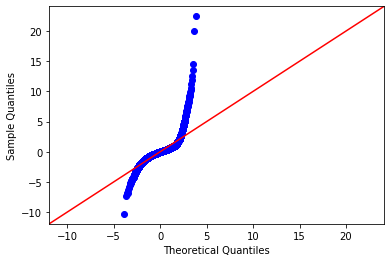

In [48]:
residuals2 = model2.resid
qq2 = sm.graphics.qqplot(residuals2, dist=stats.norm, line='45', fit=True);

## Stepwise Selection of features

In [21]:
len(X_train.columns)

89

In [22]:
results = stepwise_selection(X_train,y_train)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  grade_7                        with p-value 0.0
Add  grade_6                        with p-value 0.0
Add  waterfront                     with p-value 0.0
Add  grade_8                        with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  zipcode_98004                  with p-value 0.0
Add  zipcode_98039                  with p-value 1.48483e-215
Add  zipcode_98112                  with p-value 1.36714e-168
Add  view                           with p-value 2.0609e-180
Add  grade_12                       with p-value 6.28809e-159
Add  zipcode_98040                  with p-value 1.47364e-133
Add  grade_13                       with p-value 1.83506e-140
Add  grade_11                       with p-value 9.87537e-144
Drop                              5 with p-value 0.194881
Add  grade_10                       with p-value 1.24225e-107
Add  zipcode_98105     

In [23]:
len(results)

73

## Third Model using Selected Features

In [24]:
X_train=X_train[results]
X_test=X_test[results]

In [25]:
X_train_int = sm.add_constant(X_train)
model3 = sm.OLS(y_train, X_train_int).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1155.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:26:21   Log-Likelihood:            -2.3065e+05
No. Observations:               17277   AIC:                         4.615e+05
Df Residuals:                   17203   BIC:                         4.620e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.141e+04   1.23e+04     -2.547      0.011   -5.56e+04   -7238.912
grade_7       -8.888e+04   5077.448    -17.505      0.000   -9.88e+04   -7.89e+04
grade_6       -8.715e+04   6793.090    -12.829      0.000      -1e+05   -7.38e+04
waterfront     7.082e+05   1.54e+04     46.046      0.000    6.78e+05    7.38e+05
grade_8       -6.845e+04   4409.721    -15.523      0.000   -7.71e+04   -5.98e+04
sqft_basement   121.9284      3.730     32.686      0.000     114.617     129.240
sqft_above      174.1036      3.269     53.265      0.000     167.697     180.510
zipcode_98004  7.417e+05   1.01e+04     73.397      0.000    7.22e+05    7.62e+05
zipcode_98039  1.212e+06   2.52e+04     48.077      0.000    1.16e+06    1.26e+06
zipcode_98112  6.176e+05   1.11e+04     55.607      0.000    5.96e+05    6.39e+05
view           5.277e+04   1817.816     29.029      0.000    4.92e+04    5.63e+04
grade_12       7.616e+05   1.91e+04     39.964      0.000    7.24e+05    7.99e+05
zipcode_98040  4.803e+05   1.09e+04     44.216      0.000    4.59e+05    5.02e+05
grade_13       1.879e+06   5.51e+04     34.124      0.000    1.77e+06    1.99e+06
grade_11       3.201e+05   1.01e+04     31.657      0.000       3e+05     3.4e+05
grade_10        1.24e+05   6360.619     19.492      0.000    1.12e+05    1.36e+05
zipcode_98105  4.508e+05   1.17e+04     38.411      0.000    4.28e+05    4.74e+05
zipcode_98119  4.949e+05    1.3e+04     38.171      0.000     4.7e+05     5.2e+05
zipcode_98103  3.343e+05   7749.672     43.137      0.000    3.19e+05    3.49e+05
zipcode_98115  3.234e+05   7645.078     42.308      0.000    3.08e+05    3.38e+05
zipcode_98033  3.381e+05   8733.401     38.713      0.000    3.21e+05    3.55e+05
zipcode_98199  3.782e+05   1.02e+04     36.923      0.000    3.58e+05    3.98e+05
zipcode_98117  3.071e+05   7935.264     38.707      0.000    2.92e+05    3.23e+05
zipcode_98109  4.783e+05   1.63e+04     29.338      0.000    4.46e+05     5.1e+05
zipcode_98102  4.878e+05   1.68e+04     28.954      0.000    4.55e+05    5.21e+05
zipcode_98107   3.41e+05   1.09e+04     31.316      0.000     3.2e+05    3.62e+05
zipcode_98122   3.33e+05   1.07e+04     31.034      0.000    3.12e+05    3.54e+05
zipcode_98023 -5.441e+04   8199.936     -6.636      0.000   -7.05e+04   -3.83e+04
condition      3.349e+04   1932.746     17.329      0.000    2.97e+04    3.73e+04
zipcode_98116  2.798e+05   9960.316     28.092      0.000     2.6e+05    2.99e+05
zipcode_98042 -2.375e+04   7827.052     -3.034      0.002   -3.91e+04   -8409.137
zipcode_98092 -4.918e+04   9654.620     -5.094      0.000   -6.81e+04   -3.03e+04
zipcode_98144  2.596e+05   9839.457     26.383      0.000     2.4e+05    2.79e+05
zipcode_98006  2.274e+05   8439.647     26.948      0.000    2.11e+05    2.44e+05
zipcode_98052  2.123e+05   7758.150     27.363   

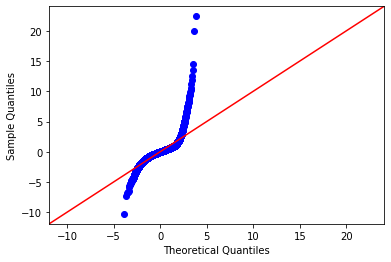

In [49]:
residuals3 = model3.resid
qq3=sm.graphics.qqplot(residuals3, dist=stats.norm, line='45', fit=True);

## Scaling features

In [26]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'zipcode',
       'sqft_living15', 'Renovated'],
      dtype='object')

In [27]:
continuous_features = ['bathrooms','sqft_above','sqft_basement',
                       'bedrooms','condition','floors','sqft_living15']
len(continuous_features)

7

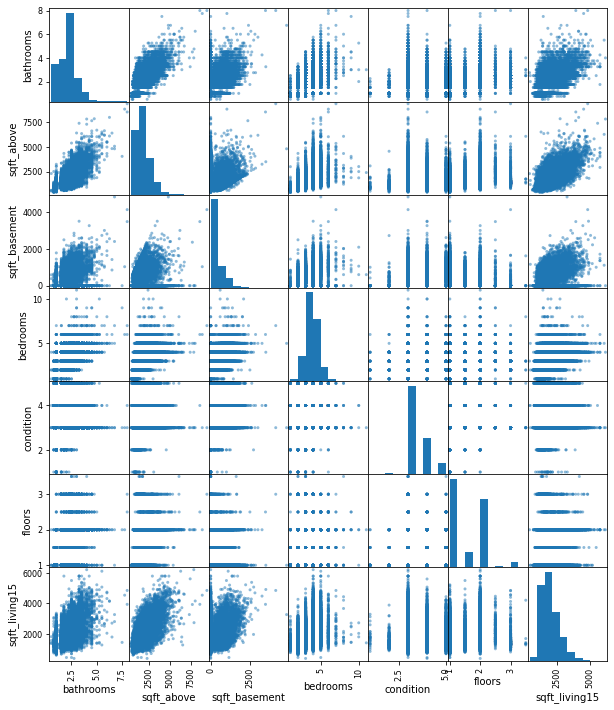

In [35]:
pd.plotting.scatter_matrix(df[continuous_features], figsize=(10,12));

In [36]:
Log_transform=['sqft_living15','sqft_above',]
for feature in Log_transform:
    X_train[feature] = X_train[feature].map(lambda x: np.log(x))
    X_test[feature] = X_test[feature].map(lambda x: np.log(x))

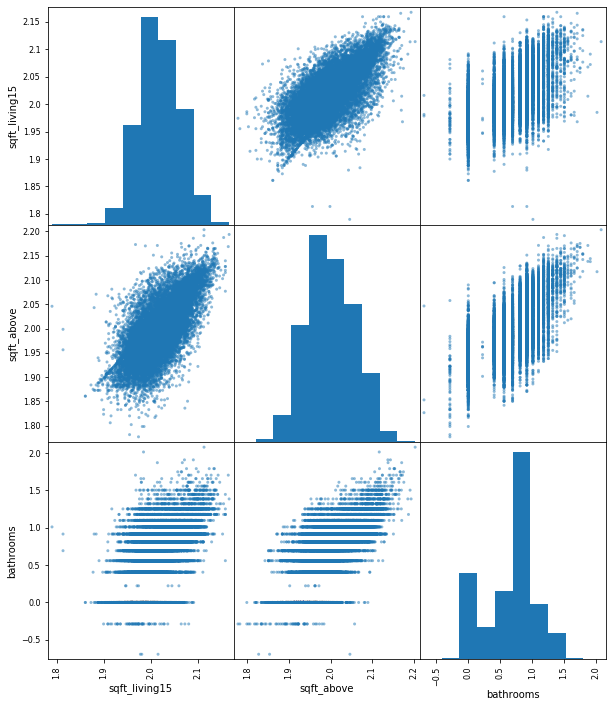

In [37]:
pd.plotting.scatter_matrix(X_train[Log_transform], figsize=(10,12));

## Fourth Model

In [32]:
X_train_int = sm.add_constant(X_train)
model4 = sm.OLS(y_train, X_train_int).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     1085.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:26:33   Log-Likelihood:            -2.3110e+05
No. Observations:               17277   AIC:                         4.624e+05
Df Residuals:                   17203   BIC:                         4.629e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.048e+06   5.22e+04    -39.215      0.000   -2.15e+06   -1.95e+06
grade_7       -1.135e+05   5122.767    -22.159      0.000   -1.24e+05   -1.03e+05
grade_6       -9.007e+04   7077.084    -12.727      0.000   -1.04e+05   -7.62e+04
waterfront     7.238e+05   1.58e+04     45.897      0.000    6.93e+05    7.55e+05
grade_8       -9.645e+04   4415.654    -21.842      0.000   -1.05e+05   -8.78e+04
sqft_basement   106.2812      3.794     28.015      0.000      98.845     113.717
sqft_above     2.779e+05   6314.594     44.003      0.000    2.65e+05     2.9e+05
zipcode_98004  7.456e+05   1.04e+04     71.915      0.000    7.25e+05    7.66e+05
zipcode_98039  1.237e+06   2.59e+04     47.831      0.000    1.19e+06    1.29e+06
zipcode_98112   6.16e+05   1.14e+04     54.038      0.000    5.94e+05    6.38e+05
view           5.075e+04   1862.835     27.241      0.000    4.71e+04    5.44e+04
grade_12       9.562e+05   1.89e+04     50.476      0.000    9.19e+05    9.93e+05
zipcode_98040  4.783e+05   1.11e+04     42.971      0.000    4.56e+05       5e+05
grade_13       2.198e+06    5.6e+04     39.265      0.000    2.09e+06    2.31e+06
grade_11       4.288e+05   9978.177     42.975      0.000    4.09e+05    4.48e+05
grade_10       1.613e+05   6434.600     25.071      0.000    1.49e+05    1.74e+05
zipcode_98105   4.54e+05   1.21e+04     37.667      0.000     4.3e+05    4.78e+05
zipcode_98119  4.937e+05   1.33e+04     37.068      0.000    4.68e+05     5.2e+05
zipcode_98103   3.39e+05   7979.372     42.484      0.000    3.23e+05    3.55e+05
zipcode_98115  3.308e+05   7858.747     42.088      0.000    3.15e+05    3.46e+05
zipcode_98033  3.379e+05   8965.103     37.685      0.000     3.2e+05    3.55e+05
zipcode_98199  3.777e+05   1.05e+04     35.904      0.000    3.57e+05    3.98e+05
zipcode_98117  3.164e+05   8166.974     38.736      0.000       3e+05    3.32e+05
zipcode_98109  4.755e+05   1.67e+04     28.412      0.000    4.43e+05    5.08e+05
zipcode_98102  4.863e+05   1.73e+04     28.102      0.000    4.52e+05     5.2e+05
zipcode_98107  3.465e+05   1.12e+04     30.912      0.000    3.25e+05    3.68e+05
zipcode_98122  3.357e+05    1.1e+04     30.424      0.000    3.14e+05    3.57e+05
zipcode_98023 -5.493e+04   8414.749     -6.528      0.000   -7.14e+04   -3.84e+04
condition      3.286e+04   1984.869     16.556      0.000     2.9e+04    3.68e+04
zipcode_98116  2.862e+05   1.02e+04     27.951      0.000    2.66e+05    3.06e+05
zipcode_98042 -2.219e+04   8030.716     -2.763      0.006   -3.79e+04   -6447.929
zipcode_98092 -4.823e+04   9909.023     -4.867      0.000   -6.76e+04   -2.88e+04
zipcode_98144  2.684e+05   1.01e+04     26.521      0.000    2.49e+05    2.88e+05
zipcode_98006  2.258e+05   8630.330     26.161      0.000    2.09e+05    2.43e+05
zipcode_98052   2.13e+05   7960.760     26.754   

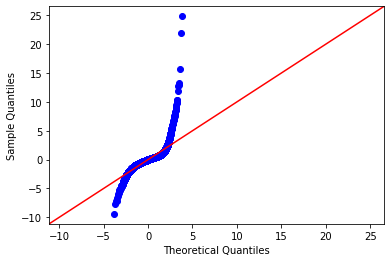

In [50]:
residuals4 = model4.resid
qq4=sm.graphics.qqplot(residuals4, dist=stats.norm, line='45', fit=True);

## Scratch Work

In [33]:
fig7 = plt.figure(figsize=(15,8))
fig7 = sm.graphics.plot_regress_exog(model3, "Age_When_Sold", fig=fig7)
plt.show()

ValueError: 'Age_When_Sold' is not in list

<Figure size 1080x576 with 0 Axes>

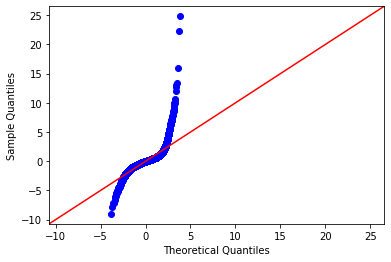

In [57]:
qq1

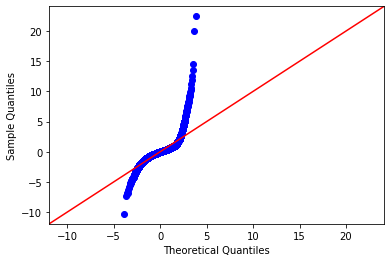

In [58]:
qq2

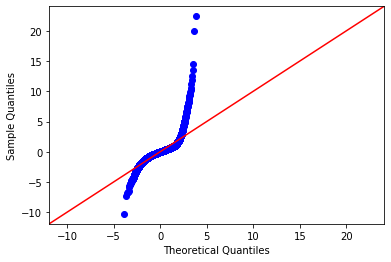

In [59]:
qq3

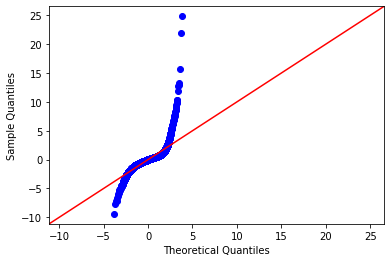

In [60]:
qq4

In [ ]:
# . predict and check rmse and looking at overfitting (for train and test)
# look at average test error
# Look at linearity between each feature with price
# Homoscadacity for model
# look at RMSE
# Look at non-linear relationships (polynomial...etc.)